Random forest, and tree-based models in general, do not handle trends well. 

The reason is simple: inside any decision tree, there are discrete rules such as:
$$
y = \begin{cases} y_1, & \text{if } x > c \\ y_2, & \text{if } x <= c \end{cases}
$$
This is a tree of depth 1 (so-called "stem"), but deeper trees obey the same logic. The variable $x$ and constants, $y_1$, $y_2$, $c$ are fit to the train data. And this is the problem: if in the training data $y$ was never higher than $y_1$, your tree will never predict $y>y_1$, even if $y$ is clearly increasing.


On the other hand, linear models (such as ARIMA and its special cases) catch trends very well. But they are poor with non-linearities and feature interplay in your data. In my own experience, the following stacking approach works best:

 1. Fit a simple time-based linear model to your data.
 2. Fit a tree-based model (random forest or boosting) to the residuals of your linear model.

If the linear model is specified correctly, it will catch and remove the non-stationarities in the data. Thus, the tree-based model will be predicting stationary residuals and find finer dependencies that the linear model.

This Python example illustrates the issue:

In [1]:
import numpy as np
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.base import copy as copy

# make a difficult dataset with a linear trend
X, y = make_friedman2(n_samples=1000, random_state=1, noise=1)
time = np.arange(1000)
y += time * 1.5
X = np.hstack([X, time[:, np.newaxis]])
X_train, y_train = X[:700], y[:700]
X_test, y_test = X[700:], y[700:]

# build a pure Random Forest
rf = RandomForestRegressor(random_state=1, n_jobs=-1).fit(X_train, y_train)
y_rf = rf.predict(X_test)

# build a pure linear model
linear = HuberRegressor().fit(X_train, y_train)
y_lin = linear.predict(X_test)

# build a stack of two models
lin_resid = y_train - cross_val_predict(linear, X_train, y_train)
rf2 = copy.copy(rf).fit(X_train, lin_resid)
y_stack = y_lin + rf2.predict(X_test)

print(r2_score(y_test, y_rf))    # R2 on test data is only 0.34
print(r2_score(y_test, y_lin))   # R2 due to time trend is 0.86 
print(r2_score(y_test, y_stack)) # R2 of combined model is 0.95

0.372790745925
0.812410952056
0.907787844309


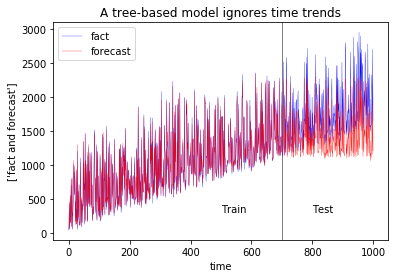

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(time, y, color='blue', lw=0.3)
plt.plot(time, rf.predict(X), color='red', lw=0.3)
ylim = plt.ylim()
plt.ylim(ylim)
plt.xlabel('time')
plt.legend(['fact', 'forecast'])
plt.ylabel(['fact and forecast'])
plt.title('A tree-based model ignores time trends')
plt.vlines(700, *ylim, lw=1, color='grey')
plt.text(500, 300, 'Train'); plt.text(800, 300, 'Test');